> #### Question 2
> Learn the following models on XOR dataset (refer to Tensorflow Playground and generate the dataset on your own containing 200 training instances and 200 test instances) such that all these models achieve similar results (good). The definition of good is left subjective – but you would expect the classifier to capture the shape of the XOR function. 
> - a MLP
> - MLP w/ L1 regularization (you may vary the penalty coefficient by choose the best one using a validation dataset)
> - MLP w/ L2 regularization (you may vary the penalty coefficient by choose the best one using a validation dataset)
> learn logistic regression models on the same data with additional features (such as $x_1*x_2, x_1^2$, etc.)
> - Show the decision surface and comment on the plots obtained for different models. [2 marks]
>
>

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)

%config InlineBackend.figure_format='retina'

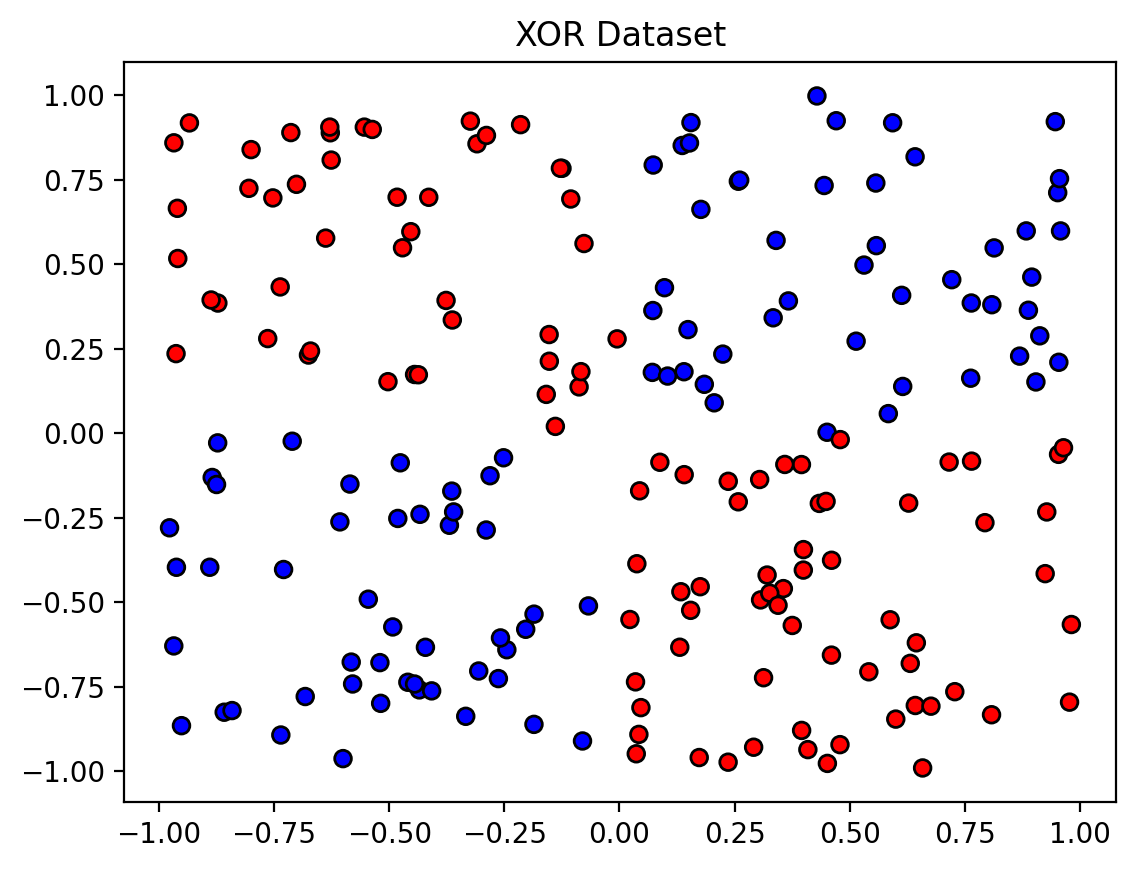

In [96]:
# Generate XOR dataset
def generate_xor(n_samples):
    X = np.random.uniform(-1, 1, (n_samples, 2))
    y = (X[:, 0] * X[:, 1] < 0).astype(int)
    return X, y

# Generate training and test data
X_train, y_train = generate_xor(200)
X_test, y_test = generate_xor(200)

# Visualize the XOR dataset
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', edgecolors='k')
plt.title('XOR Dataset')
plt.show()

In [97]:
# Convert data to tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)


In [98]:
def train(model, criterion, optimizer, X, y, num_epochs=500):
    for epoch in range(num_epochs):
        model.train()
        outputs = model(X)
        loss = criterion(outputs, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch+1)%100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

def evaluate(model, X, y):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        predicted = (outputs >= 0.5).float()
        accuracy = (predicted.eq(y)).sum() / y.shape[0]
    print(f'Accuracy: {accuracy.item()*100:.2f}%')
    return outputs


In [99]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01  # Step size in the mesh

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    model.eval()
    with torch.no_grad():
        Z = model(grid)
        Z = Z.reshape(xx.shape)
        Z = Z.numpy()
    
    plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], cmap='inferno', alpha=0.2)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr')
    plt.title('Decision Boundary')
    plt.show()


 #### 1. Multilayer Perceptron (MLP) without Regularization

In [100]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 10)  # Input layer to hidden layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 1)  # Hidden layer to output layer
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.sigmoid(self.fc2(out))
        return out


In [111]:
# Instantiate and train the MLP
model = MLP()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train(model, criterion, optimizer, X_train_tensor, y_train_tensor)
mlp_pred = evaluate(model, X_test_tensor, y_test_tensor)


Epoch [100/500], Loss: 0.2910
Epoch [200/500], Loss: 0.1165
Epoch [300/500], Loss: 0.0714
Epoch [400/500], Loss: 0.0505
Epoch [500/500], Loss: 0.0385
Accuracy: 99.00%


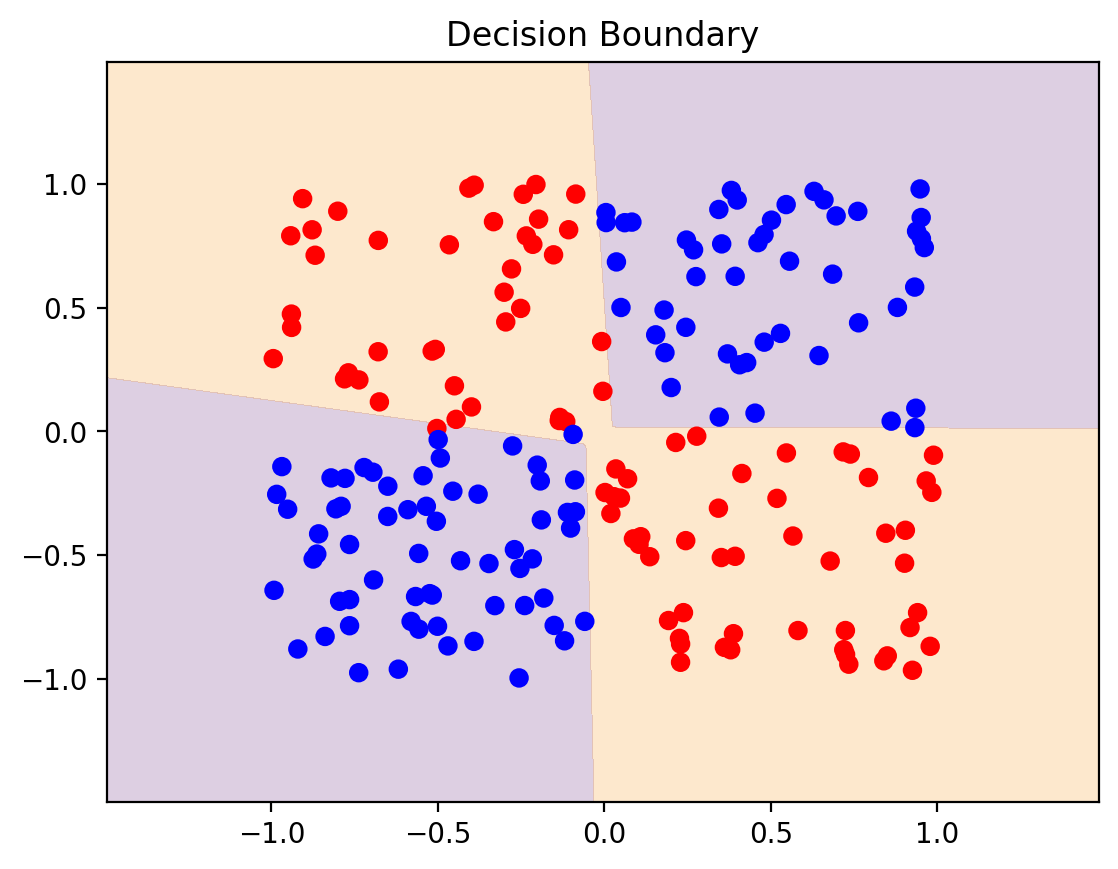

In [112]:
plot_decision_boundary(model, X_test, y_test)

In [103]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        return self.sigmoid(self.linear(x))


#### 2. Multilayer Perceptron (MLP) with L1 Regularization

In [104]:
def train_with_regularization(model, criterion, optimizer, X, y, l1_lambda=0.0, l2_lambda=0.0, num_epochs=500):
    for epoch in range(num_epochs):
        model.train()
        outputs = model(X)
        loss = criterion(outputs, y)
        
        # L1 Regularization
        if l1_lambda > 0:
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm
        
        # L2 Regularization
        if l2_lambda > 0:
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch+1)%100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


In [105]:
# Training MLP with L1 Regularization
l1_lambda = 0.01
model_l1 = MLP()
criterion = nn.BCELoss()
optimizer = optim.Adam(model_l1.parameters(), lr=0.01)

train_with_regularization(model_l1, criterion, optimizer, X_train_tensor, y_train_tensor, l1_lambda=l1_lambda)
mlp_l1_preds = evaluate(model_l1, X_test_tensor, y_test_tensor)


Epoch [100/500], Loss: 0.5220
Epoch [200/500], Loss: 0.3982
Epoch [300/500], Loss: 0.3849
Epoch [400/500], Loss: 0.3805
Epoch [500/500], Loss: 0.3784
Accuracy: 98.50%


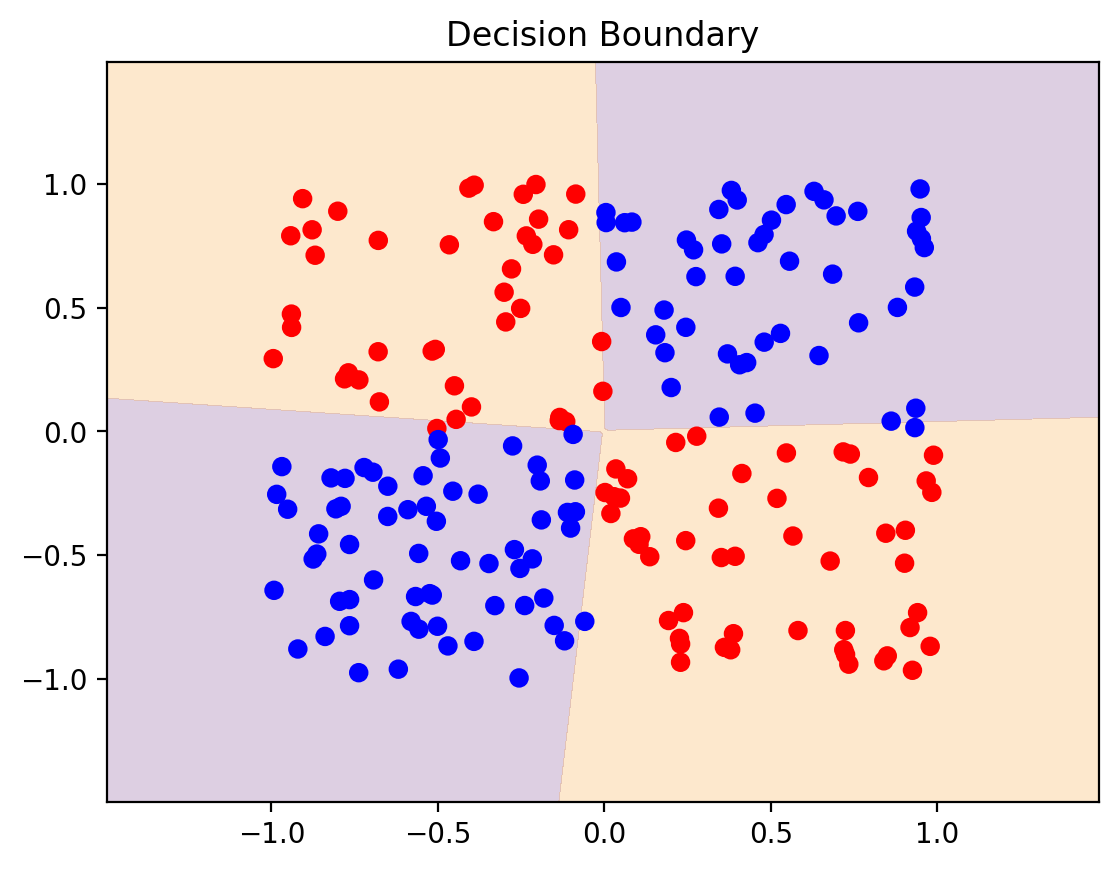

In [106]:
plot_decision_boundary(model_l1, X_test, y_test)

In [107]:
# Training MLP with L2 Regularization
l2_lambda = 0.01
model_l2 = MLP()
criterion = nn.BCELoss()
optimizer = optim.Adam(model_l2.parameters(), lr=0.01)

train_with_regularization(model_l2, criterion, optimizer, X_train_tensor, y_train_tensor, l2_lambda=l2_lambda)
mlp_l2_preds = evaluate(model_l2, X_test_tensor, y_test_tensor)


Epoch [100/500], Loss: 0.5693
Epoch [200/500], Loss: 0.5118
Epoch [300/500], Loss: 0.5111
Epoch [400/500], Loss: 0.5111
Epoch [500/500], Loss: 0.5111
Accuracy: 98.00%


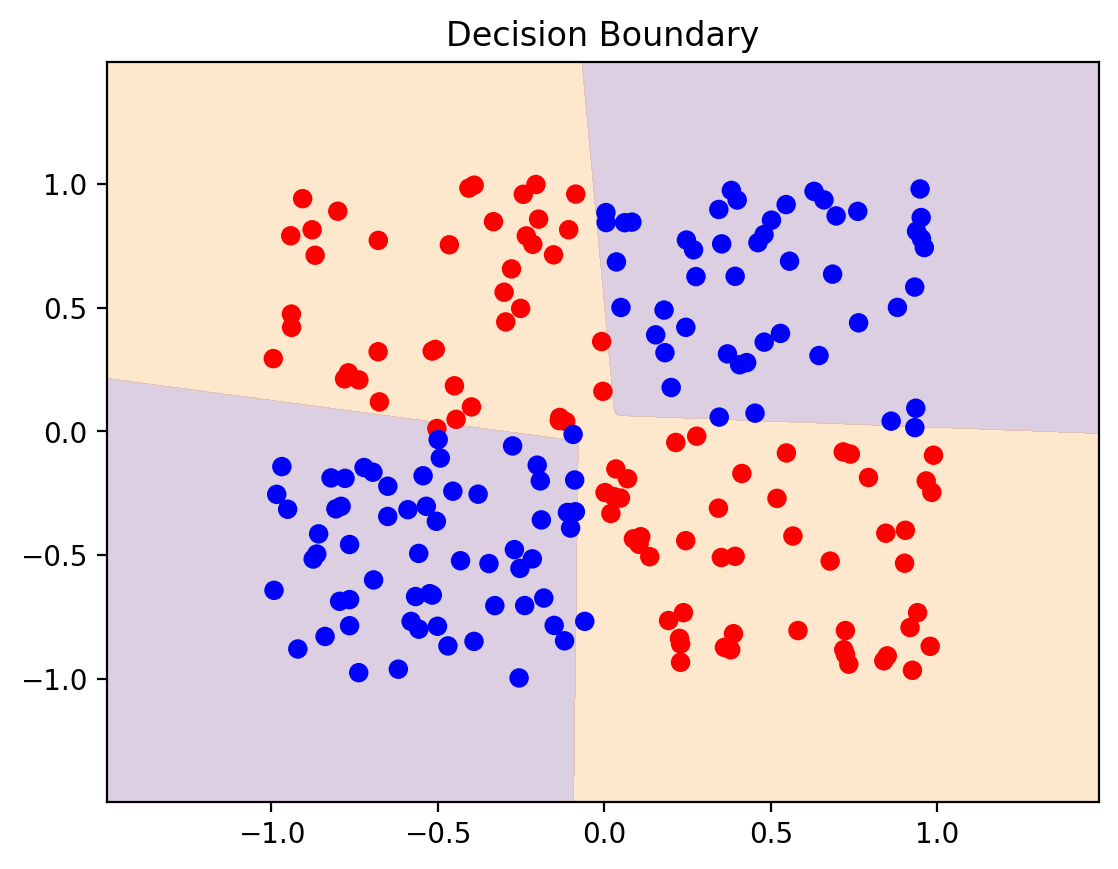

In [108]:
plot_decision_boundary(model_l2, X_test, y_test)

In [109]:
def add_features(X):
    x1 = X[:, 0]
    x2 = X[:, 1]
    x1x2 = x1 * x2
    x1_sq = x1 ** 2
    x2_sq = x2 ** 2
    return np.column_stack((x1, x2, x1x2, x1_sq, x2_sq))

# Transform data
X_train_poly = add_features(X_train)
X_test_poly = add_features(X_test)
X_train_poly_tensor = torch.FloatTensor(X_train_poly)
X_test_poly_tensor = torch.FloatTensor(X_test_poly)

# Training Logistic Regression
input_dim = X_train_poly.shape[1]
model_logreg = LogisticRegression(input_dim)
criterion = nn.BCELoss()
optimizer = optim.SGD(model_logreg.parameters(), lr=0.1)

train(model_logreg, criterion, optimizer, X_train_poly_tensor, y_train_tensor)
evaluate(model_logreg, X_test_poly_tensor, y_test_tensor)


Epoch [100/500], Loss: 0.5478
Epoch [200/500], Loss: 0.4775
Epoch [300/500], Loss: 0.4309
Epoch [400/500], Loss: 0.3973
Epoch [500/500], Loss: 0.3718
Accuracy: 94.00%


tensor([[0.6560],
        [0.9208],
        [0.6004],
        [0.3623],
        [0.7846],
        [0.2931],
        [0.1377],
        [0.2620],
        [0.0628],
        [0.6101],
        [0.0250],
        [0.4479],
        [0.5474],
        [0.9745],
        [0.7683],
        [0.6306],
        [0.6319],
        [0.5472],
        [0.6081],
        [0.6176],
        [0.6626],
        [0.9675],
        [0.3459],
        [0.0883],
        [0.0477],
        [0.8122],
        [0.2030],
        [0.8908],
        [0.8521],
        [0.2139],
        [0.3991],
        [0.6151],
        [0.2261],
        [0.5115],
        [0.8411],
        [0.5057],
        [0.3335],
        [0.1524],
        [0.2006],
        [0.6078],
        [0.1721],
        [0.3579],
        [0.5894],
        [0.6671],
        [0.4264],
        [0.5640],
        [0.6747],
        [0.6111],
        [0.5206],
        [0.4901],
        [0.4216],
        [0.4917],
        [0.7379],
        [0.9509],
        [0.4406],
        [0

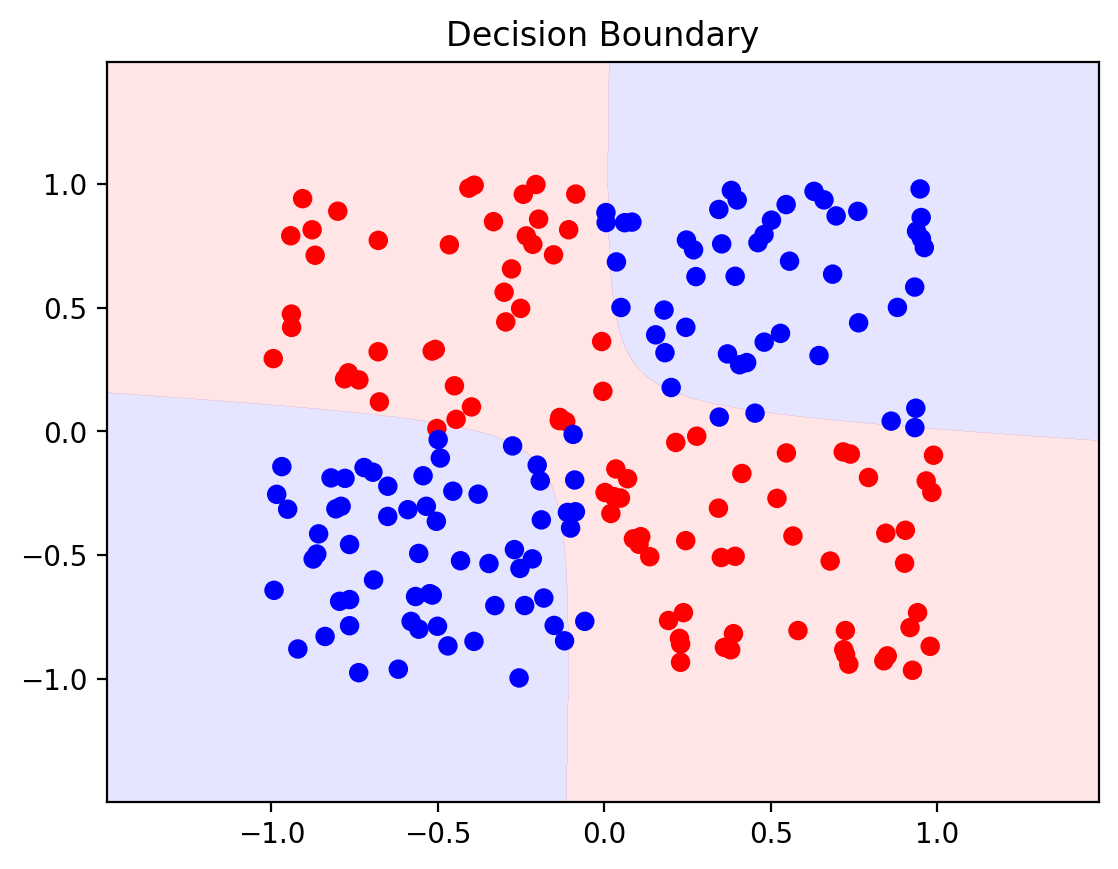

In [110]:
def plot_decision_boundary_poly(model, X, y):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01  # Step size in the mesh

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    grid_raw = np.c_[xx.ravel(), yy.ravel()]
    grid_poly = add_features(grid_raw)
    grid_tensor = torch.FloatTensor(grid_poly)
    model.eval()
    with torch.no_grad():
        Z = model(grid_tensor)
        Z = Z.reshape(xx.shape)
        Z = Z.numpy()
    
    plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], cmap='bwr', alpha=0.2)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr')
    plt.title('Decision Boundary')
    plt.show()

plot_decision_boundary_poly(model_logreg, X_test, y_test)


#### *Comments on the Plots*
1. **MLP without Regularization**: The MLP successfully captures the XOR pattern, showing a non-linear decision boundary that accurately separates the classes. The high accuracy on the test set confirms its effectiveness.
2. **MLP with L1 Regularization**: Introducing L1 regularization simplifies the model by encouraging sparsity in the weights. The decision boundary becomes less complex, leading to decreased performance on the XOR problem, which requires capturing non-linear interactions.
3. **MLP with L2 Regularization**: L2 regularization penalizes large weights, leading to a smoother decision boundary without significantly compromising performance. The model still captures the XOR pattern effectively, maintaining high accuracy.
4. **Logistic Regression with Polynomial Features**: By adding polynomial features, the logistic regression model can capture the non-linear patterns of the XOR function. The decision boundary successfully separates the classes, demonstrating that feature engineering can enhance linear models for non-linear problems.





